I have a 2D matrix of molecules for a simplified water droplet model. I will assume the molecules are evaporating from the outer circle inwards. A molecule needs to absorb enough energy to overcome vapor pressure and break its hydrogen bonds to then escape into the surrounding air as a gas. I am going to ignore vapor pressure for the moment and just focus on hydrogen bonds. At the beginning of the simulation I will have to input a temperature. I will then iterate through the molecules around the edge of my matrix randomly. I will assume the Maxwell-Boltzmann distribution applies. I will use this distribution to obtain a velocity for my molecule. I will use this velocity to calculate the kinetic energy of my molecule. If the kinetic energy is bigger than the hydrogen bond energy, the molecule breaks free and I remove it from my matrix.

 

Pseudocode:

-       Input temperature

-       Create matrix NxN filled with 1s (to represent a present molecule, 0 for evaporated)

-       Generate random number to select a cell around the edge

-       Obtain the velocity of this molecule

o   Generate a random number from a uniform distribution and use the inverse of the CDF of the Maxwell-Boltzmann distribution to obtain a velocity

-       Calculate the kinetic energy of the molecule (1/2 m v^2)

-       If (kinetic energy)>(hydrogen bond energy)

o   Molecule evaporates

o   Sent cell =0

-       Else run again

 

 

As molecules evaporate this will cause the remaining water molecules to decrease in temperature. I have not made this part of my model. I will do more research into this to see if I could incorporate it into the model as well. I will also look into including vapor pressure. 

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
#Creates a matrix of 1's to represent water molecules
def createDroplet(N):
    return np.full((N,N),1) #Creating the water droplet matrix



In [5]:
#Returns coordinates for a random molecule in the matrix
def randomMolecule(droplet):
    N,M=np.shape(droplet)

    i=random.randint(0,N-1)
    j=random.randint(0,M-1)
    return i,j

In [6]:
def maxwellBoltzmannDistribution(x, T):
    
    k=1.380649*10**(-23) #Boltzmann constant
    m=2.9915*10**(-23)*10**(-3) #mass of a water molecule in kg
    return np.sqrt(2/np.pi)*(m/(k*T))**(3/2)*x**2*np.exp(-m*x**2/(2*k*T))

In [7]:
def getMoleculeVelocity(T):
    
    #Rejection Method for selecting a random number according to a probability distribution
    i=0
    while i<10:
        i+=1
        #Find bounding value of PDF (most probable value)
        v_p=np.sqrt(2*8.3144621*T/0.01801528) #M (molar mass of H2O)=18.01528e-3 kg/mol, R(gas constant of H20)=8.3144621 J.mol^-1.K^-1
        
        #Find probability of obtaining v_p
        probv_p=maxwellBoltzmannDistribution(v_p,T)

        #Pick an x uniformly in the domain of the PDF (our PDF goes to 0 after 1000)
        x=0+(1000-0)*random.random()

        #Pick a y uniformly between 0 and v_p
        y=probv_p*random.random()

        probx=maxwellBoltzmannDistribution(x,T)

        if y<probx:
            return x
    
    return x
print(getMoleculeVelocity(300))

539.6086398054305


In [8]:
def getKineticEnergy(T):
    v=getMoleculeVelocity(T)
    m=2.988*10**(-26) #mass of water molecule 2.988e-26 kg
    kineticEnergy=(1/2)*m*v**2
    return kineticEnergy

print(getKineticEnergy(300))

1.5410948181509488e-21


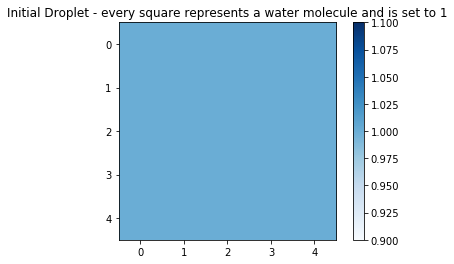

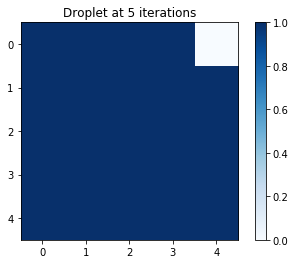

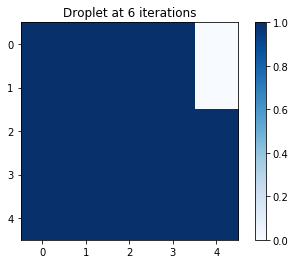

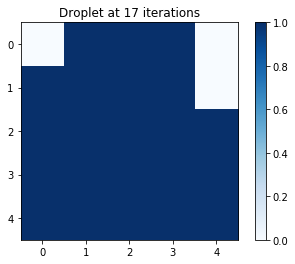

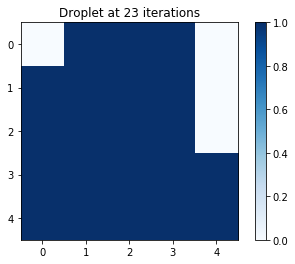

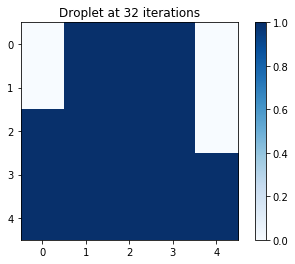

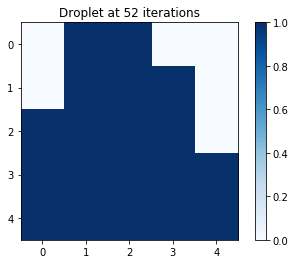

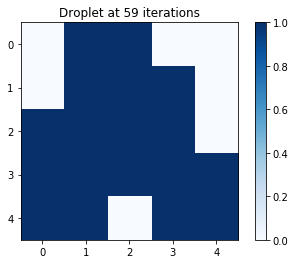

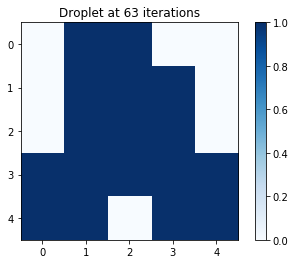

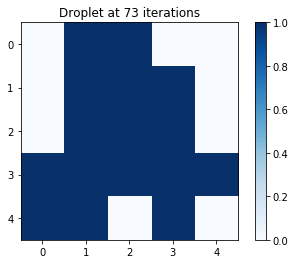

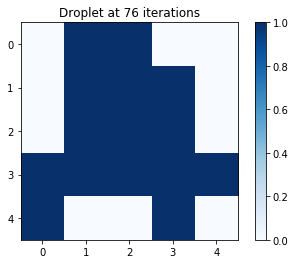

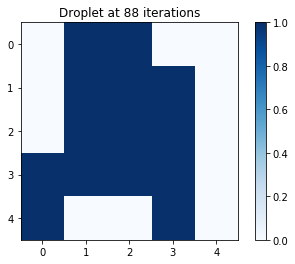

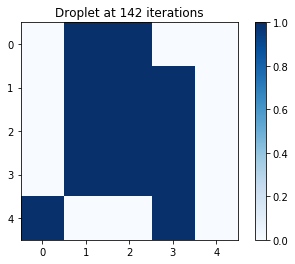

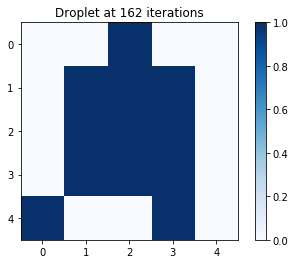

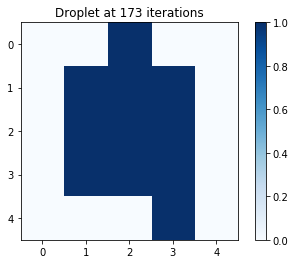

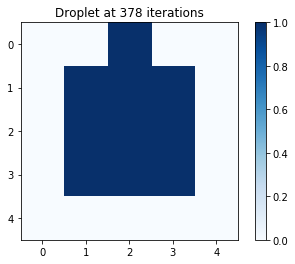

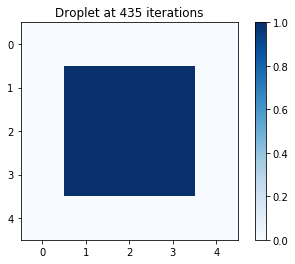

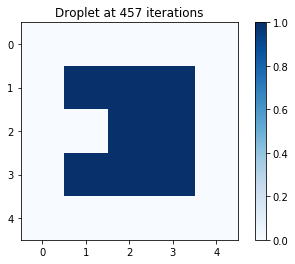

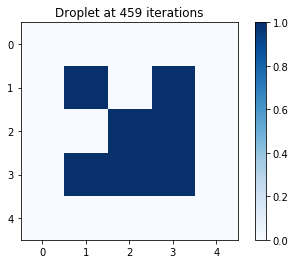

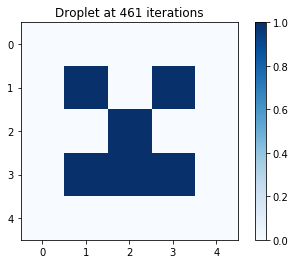

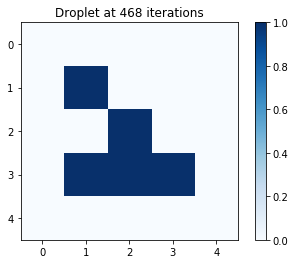

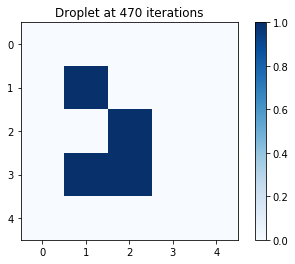

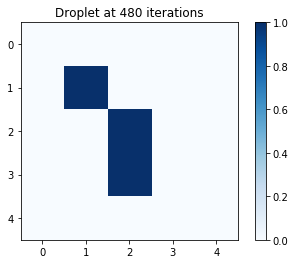

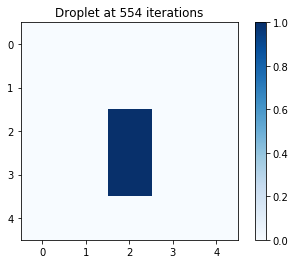

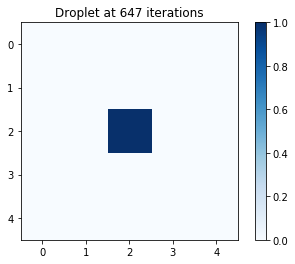

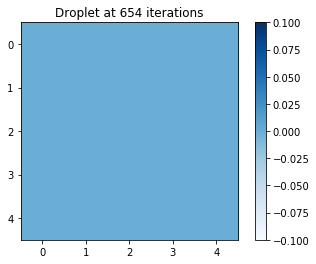

654


<Figure size 432x288 with 0 Axes>

In [112]:
T=500 #Set air temperature
N=5 #Size of droplet


def evaporate(N,T, visualize=True):
    
    hydrogenBondEnergy=9.9632*10**(-21) #energy of a hydrogen bond for water molecule
    #Energy of a hydrogen bond is 6-30 kJ/mol (≈2-12 kBT), (6000-30 000 J/mol => 9.9632e-21 - 4.9816e-20 J per molecule of H_2O)

    droplet=createDroplet(N) #create initial water droplet
    
    #Plotting initial water droplet visualization
    if visualize:
        plt.title('Initial Droplet - every square represents a water molecule and is set to 1')
        plt.imshow(droplet,cmap='Blues')
        plt.colorbar()
        plt.savefig('DropletEvaporationPlots/Droplet0.pdf')
        plt.show()

    direction=0 #0 means right, 1 means down, 2 means left, 3 means up
    column=0
    row=0
    layer=1
    layer_count=0
    counter=0
    iterations=0

    while (counter<N*N and iterations<5000):
        iterations+=1
        if droplet[row][column]==1:
            kineticEnergy=getKineticEnergy(T)
            if kineticEnergy>hydrogenBondEnergy:
                droplet[row][column]=0
                counter+=1
                layer_count+=1
                if visualize:
                    plt.imshow(droplet,cmap='Blues')
                    plt.colorbar()
                    plt.title('Droplet at %d iterations' %iterations)
                    plt.savefig('DropletEvaporationPlots/Droplet%d.pdf'%iterations)
                    plt.show()

        if direction==0 and column<(N-layer):
                column+=1
                if column == (N-layer):
                    direction=1
        elif direction==1 and row<(N-layer):
                row+=1
                if row ==(N-layer):
                    direction=2
        elif direction==2 and column>layer-1:
                column-=1
                if column == layer-1:
                    direction=3
        elif direction==3 and row>layer-1:
                row-=1
                if row == layer-1:
                    direction=0
                    if (N-(2*(layer-1)))*4-4==layer_count: #if (N-layer+1)*4-4==layer_count:
                        row+=1
                        layer+=1
                        layer_count=0
                        
                        
    return iterations


print(evaporate(5,300,True))
plt.tight_layout()

596.48

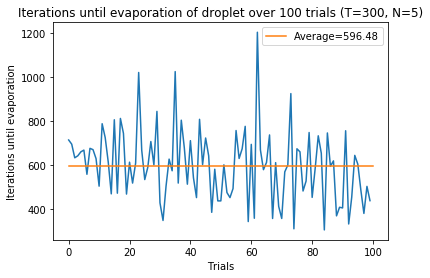

In [108]:
#Plot iterations until evaporation for a set temperature


def iterationsUntilEvaporation(N,T,trials,Plot=True):
    arr=[]

    for i in range(trials):
        arr.append(evaporate(N,T,False))
    
    average=sum(arr)/len(arr)
    
    if Plot:
        plt.plot(arr)
        plt.title('Iterations until evaporation of droplet over 100 trials (T=%d, N=%d)'%(T,N))
        plt.xlabel('Trials')
        plt.ylabel('Iterations until evaporation')

        x=np.linspace(0,len(arr),len(arr))
        y=np.full(len(arr),average)

        plt.plot(x,y,label='Average='+str(average))
        plt.legend()

        plt.savefig('iterationsvstrials.pdf')
    
    return average
    
    

iterationsUntilEvaporation(5,300,100,True)


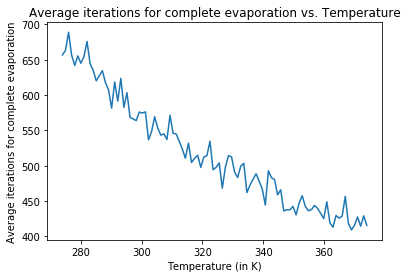

In [107]:
#Plot of average iterations needed for complete evaporation vs. Temperature
#Water freezes at 273 K
#For 5x5 droplet matrix

iteravgarr=[]
for i in range(274,374):
    iteravgarr.append(iterationsUntilEvaporation(5,i,100,False))


temps=np.linspace(274,374,100)
plt.plot(temps,iteravgarr)
plt.title('Average iterations for complete evaporation vs. Temperature')
plt.xlabel('Temperature (in K)')
plt.ylabel('Average iterations for complete evaporation')
plt.savefig('avgitervstemp.pdf')

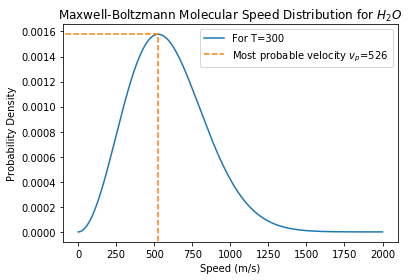

In [27]:
#Plot of Maxwell-Boltzmann Distribution

T=300 #room temperature is 293-298 K
k=1.380649*10**(-23) #Boltzmann constant
m=2.9915*10**(-23)*10**(-3) #mass of a water molecule in kg


x=np.linspace(0,2000,2000)
y=np.sqrt(2/np.pi)*(m/(k*T))**(3/2)*x**2*np.exp(-m*x**2/(2*k*T)) #Maxwell-Boltzmann Distribution 

v_p=int(np.sqrt(2*8.3144621*T/0.01801528)) #Maximum value fo the PDF (most probable velocity)

#Plotting the distribution function
plt.plot(x,y)
plt.title(r'Maxwell-Boltzmann Molecular Speed Distribution for $H_2O$')
plt.ylabel('Probability Density')
plt.xlabel('Speed (m/s)')

#Showing the maximum value v_p
xlim,ylim = plt.xlim(), plt.ylim()
plt.plot([x[v_p], x[v_p], xlim[0]], [xlim[0], y[v_p], y[v_p]],
          linestyle="--")
plt.xlim(xlim)
plt.ylim(ylim)
plt.legend(['For T='+str(T),r'Most probable velocity $v_p$='+str(v_p)])

plt.savefig('distributionplot.pdf')